In [1]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense,AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


In [8]:
#Load dataset
(X_c_train, y_c_train), (X_c_test, y_c_test) = cifar100.load_data(label_mode='coarse')
(X_f_train, y_f_train), (X_f_test, y_f_test) = cifar100.load_data(label_mode='fine')

X_train = X_c_train
X_test = X_c_test
y_train = [y_c_train, y_f_train]
y_test = [y_c_test, y_f_test]

image_size = X_train[0].shape

num_classes_c = len(set([v[0] for v in y_c_train]))
num_classes_f = len(set([v[0] for v in y_f_train]))



In [9]:
def get_model1():
    # Conv base
    in_layer = Input(shape=image_size, dtype='float32', name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # coarse output
    out_c = Dense(num_classes_c, activation="softmax", name='out_c')(conv_base)
    # fine output 
    out_f = Dense(num_classes_f, activation="softmax", name='out_f')(conv_base)
    # Build the model
    model = Model(
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[0.5, 0.5],
                  metrics=['accuracy'])
    return model


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_c (Dense)                   (None, 20)           10260       flatten_1[0][0]                  
____________________________________________________________________________________________

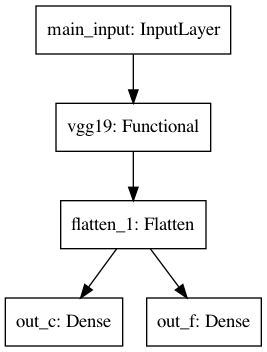

In [10]:
# Create the model
model = get_model1()
model.summary()
plot_model(model)

In [ ]:
#train model
batch = 64
history = model.fit(X_train, 
                    y_train,
                    validation_data = (X_test, y_test), 
                    batch_size=batch, 
                    epochs=15)


In [ ]:
out_f_accuracy = history.history['out_f_accuracy']
out_c_accuracy = history.history['out_c_accuracy']
val_out_f_accuracy = history.history['val_out_f_accuracy']
val_out_c_accuracy = history.history['val_out_c_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(15,4))

ax1 = plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.fill_between(epochs, loss,val_loss,color='g',alpha=.1)

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
plt.plot(epochs, out_f_accuracy, label='Training f accuracy')
plt.plot(epochs, out_c_accuracy, label='Training c accuracy')
plt.plot(epochs, val_out_f_accuracy, label='Validation f accuracy')
plt.plot(epochs, val_out_c_accuracy, label='Validation c accuracy')
# plt.fill_between(epochs, acc,val_acc,color='g',alpha=.1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()